# Description

1. Collect the mice data from here https://www.nature.com/articles/s41588-023-01399-7#data-availability
2. Use that as outoff sample data (genes x samples) to generate B matrix (lvs x samples) from VAE and PLIER models
3. Run permutation multiple group analysis on generate B matrices from VAE and PLIER.

# Modules

In [81]:
# reload imported modules if changed
%load_ext autoreload
%autoreload 2

import pprint

import joblib
import matplotlib.pyplot as plt
import numpy as np
import random
import pyreadr
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr, permutation_test, f_oneway, ranksums 
from statsmodels.stats.multitest import multipletests
import dcor

from pvae import conf
from pvae.data import FeatherDataset
from pvae.models import VariationalAutoencoder
from pvae.models_utils import train_vae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings and paths

In [82]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
display(DEVICE)

'cuda'

In [83]:
# Model parameters
K = 168
KL_L = 1.0
PRED_L = 2.0

# Others parameters
K_FOLDS = 3
N_FOLDS_TO_RUN = None  # None to run all K_FOLDS (used for testing)
N_EPOCS = 50
BATCH_SIZE = 50
PATHWAYS_TRAINING_PERC = 0.80
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0
RANDOM_SEED = 0

In [84]:
# Paths
OUTPUT_FOLDER = (
    conf.data.OUTPUT_DIR
    / "models"
    / "mice_vae"
    / f"k_{K}-kl_l_{KL_L}-pred_l_{PRED_L}-batch_size_{BATCH_SIZE}-lr_{LEARNING_RATE:.0e}-n_epochs_{N_EPOCS}"
)
VAE_MODEL_OUTPUT_FILE = "fold_{fold}-mice_vae_model.pt"
DATA_SCALER_OUTPUT_FILE = "fold_{fold}-data_scaler.joblib"

In [85]:
# INPUT_FILES and OUTPUT_FILES must be provided if running with pytask
INPUT_FILES = {
    "mice_gene_expr_data_input": conf.data.MICE_PROCESSED_DIR
    / "mice_data-full-log.ftr",
    "mice_gene_expr_norm_adult_heart_input": conf.data.MICE_PROCESSED_DIR
    / "mice_gene_expr_norm_adult_heart_rpkm_std.ftr",
    "mice_gene_expr_norm_brain_input": conf.data.MICE_PROCESSED_DIR
    / "mice_gene_expr_norm_brain_rpkm_std.ftr",
    "mice_gene_expr_mesenteric_lymph_nodes_input": conf.data.MICE_PROCESSED_DIR
    / "mice_gene_expr_mesenteric_lymph_nodes_rpkm_std.ftr",
    "mice_gene_expr_facial_mesenchyme_input": conf.data.MICE_PROCESSED_DIR
    / "mice_gene_expr_facial_mesenchyme_rpkm_std.ftr",
    "mice_plier_model_Z": conf.data.MICE_PROCESSED_DIR
    / "mice_model_Z_std.csv",
    "mice_plier_model_B": conf.data.MICE_PROCESSED_DIR
    / "mice_model_B_std.csv"}

OUTPUT_FILES = {
    f"mice_vae_model_fold{i}": OUTPUT_FOLDER / VAE_MODEL_OUTPUT_FILE.format(fold=i)
    for i in range(min(K_FOLDS, N_FOLDS_TO_RUN or K_FOLDS))
}
OUTPUT_FILES.update(
    {
        f"data_scaler_fold{i}": OUTPUT_FOLDER / DATA_SCALER_OUTPUT_FILE.format(fold=i)
        for i in range(min(K_FOLDS, N_FOLDS_TO_RUN or K_FOLDS))
    }
)
OUTPUT_FILES.update({"performance_stats": OUTPUT_FOLDER / "performance_stats.pkl"})
OUTPUT_FILES.update({"mice_gene_expr_norm_adult_heart_vae_B_matrix": OUTPUT_FOLDER / "mice_gene_expr_norm_adult_heart_vae_B_matrix.ftr"})
OUTPUT_FILES.update({"mice_gene_expr_norm_adult_heart_plier_B_matrix": OUTPUT_FOLDER / "mice_gene_expr_norm_adult_heart_plier_B_matrix.ftr"})

In [86]:
pprint.pprint(INPUT_FILES)

{'mice_gene_expr_data_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_data-full-log.ftr'),
 'mice_gene_expr_facial_mesenchyme_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_gene_expr_facial_mesenchyme_rpkm_std.ftr'),
 'mice_gene_expr_mesenteric_lymph_nodes_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_gene_expr_mesenteric_lymph_nodes_rpkm_std.ftr'),
 'mice_gene_expr_norm_adult_heart_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_gene_expr_norm_adult_heart_rpkm_std.ftr'),
 'mice_gene_expr_norm_brain_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_gene_expr_norm_brain_rpkm_std.ftr'),
 'mice_plier_model_B': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_model_B_std.csv'),
 'mice_plier_model_Z': PosixPath('/ho

In [87]:
pprint.pprint(OUTPUT_FILES)

{'data_scaler_fold0': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_0-data_scaler.joblib'),
 'data_scaler_fold1': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_1-data_scaler.joblib'),
 'data_scaler_fold2': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_2-data_scaler.joblib'),
 'mice_gene_expr_norm_adult_heart_plier_B_matrix': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/mice_gene_expr_norm_adult_heart_plier_B_matrix.ftr'),
 'mice_gene_expr_norm_adult_heart_vae_B_matrix': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-

In [88]:
for _k, v in OUTPUT_FILES.items():
    v.parent.mkdir(parents=True, exist_ok=True)

# Load data

## FeatherDataset

In [89]:
orig_dataset = pd.read_feather(INPUT_FILES["mice_gene_expr_data_input"]).set_index("index")
new_dataset_adult_heart = pd.read_feather(INPUT_FILES["mice_gene_expr_norm_adult_heart_input"])
new_dataset_brain = pd.read_feather(INPUT_FILES["mice_gene_expr_norm_brain_input"])
new_dataset_mesenteric_lymph_nodes = pd.read_feather(INPUT_FILES["mice_gene_expr_mesenteric_lymph_nodes_input"])
new_dataset_facial_mesenchyme = pd.read_feather(INPUT_FILES["mice_gene_expr_facial_mesenchyme_input"])

In [90]:
orig_dataset.shape

(10849, 190110)

# Make new dataset gene same as original set #

In [91]:
def new_dataset_with_gene_match_from_old_data(new_dataset, orig_dataset):
    new_set = set(new_dataset.index.tolist())
    orig_set = set(orig_dataset.index.tolist())
    common_set = new_set.intersection(orig_set)
    # print("common gene set :", len(common_set))
    gene_not_in_new_set = orig_set - common_set
    gene_not_in_orig_set = new_set - common_set
    
    for gene in gene_not_in_new_set:
        new_dataset.loc[gene] = [0]* len(new_dataset.columns)
    new_dataset = new_dataset.drop(gene_not_in_orig_set)
    assert len(new_dataset.index.tolist()) == len(orig_dataset.index.tolist())

    assert orig_dataset.isnull().any().any() == False
    assert new_dataset.isnull().any().any() == False 
    assert orig_dataset.isna().any().any() == False
    assert new_dataset.isna().any().any() == False
    return new_dataset 

# Join new labeled data based on Tissue type # 

In [92]:
new_dataset_label_sample_dict = {}
new_dataset_adult_heart_matched_genes = new_dataset_with_gene_match_from_old_data(new_dataset_adult_heart, orig_dataset)
new_dataset_adult_heart_matched_genes = new_dataset_adult_heart_matched_genes.T
print(new_dataset_adult_heart_matched_genes.index.tolist())
heart_labels = ["heart"] * len(new_dataset_adult_heart_matched_genes.index.tolist())
new_dataset_label_sample_dict["heart"] = new_dataset_adult_heart_matched_genes.index.tolist()

new_dataset_brain_genes = new_dataset_with_gene_match_from_old_data(new_dataset_brain, orig_dataset)
new_dataset_brain_genes = new_dataset_brain_genes.T
brain_labels = ["brain"] * len(new_dataset_brain_genes.index.tolist())
print(new_dataset_brain_genes.index.tolist())
new_dataset_label_sample_dict["brain"] = new_dataset_brain_genes.index.tolist()

new_dataset_mesenteric_lymph_nodes_genes = new_dataset_with_gene_match_from_old_data(new_dataset_mesenteric_lymph_nodes, orig_dataset)
new_dataset_mesenteric_lymph_nodes_genes = new_dataset_mesenteric_lymph_nodes_genes.T
mesenteric_labels = ["mesenteric_lymph_nodes"] * len(new_dataset_mesenteric_lymph_nodes_genes.index.tolist())
print(new_dataset_mesenteric_lymph_nodes_genes.index.tolist())
new_dataset_label_sample_dict["mesenteric_lymph_nodes"] = new_dataset_mesenteric_lymph_nodes_genes.index.tolist()

new_dataset_facial_mesenchyme_genes = new_dataset_with_gene_match_from_old_data(new_dataset_facial_mesenchyme, orig_dataset)
new_dataset_facial_mesenchyme_genes = new_dataset_facial_mesenchyme_genes.T
facial_mesenchyme_labels = ["facial_mesenchyme"] * len(new_dataset_facial_mesenchyme_genes.index.tolist())
print(new_dataset_facial_mesenchyme_genes.index.tolist())
new_dataset_label_sample_dict["facial_mesenchyme"] = new_dataset_facial_mesenchyme_genes.index.tolist()

new_dataset = pd.concat([new_dataset_adult_heart_matched_genes, new_dataset_brain_genes, 
                         new_dataset_mesenteric_lymph_nodes_genes, new_dataset_facial_mesenchyme_genes])
new_dataset_labels = heart_labels + brain_labels + mesenteric_labels + facial_mesenchyme_labels
# new_dataset_label_sample_dict = dict(zip(new_dataset.index.tolist(), new_dataset_labels))
labels_set = set(new_dataset_labels)
display(new_dataset_label_sample_dict)

['T0_930_Ht', 'T11_933_Ht', 'T13_936_Ht', 'T3_048_Ht', 'T2_480_Ht', 'T1_930_Ht', 'T0_937_Ht', 'T8_931_Ht', 'T6_046_Ht', 'T0_476_Ht', 'T5_480_Ht', 'T2_930_Ht', 'T8_936_Ht', 'T6_931_Ht', 'T2_935_Ht', 'T5_048_Ht']
['T5307_467_Br', 'T4_589_Br', 'T5_589_Br', 'T6_591_Br', 'T3_591_Br', 'T2_698_Br', 'T5305_467_Br', 'T4_135_Br', 'T4_507_Br', 'T7_578_Br', 'T3_582_Br', 'T5306_467_Br', 'T2_599_Br', 'T1_603_Br', 'T3_603_Br', 'T6_590_Br', 'T4_603_Br', 'T8_907_Br']
['T0_930_mLN', 'T11_933_mLN', 'T13_936_mLN', 'T13_028_mLN', 'T2_047_mLN', 'T1_930_mLN', 'T0_937_mLN', 'T8_931_mLN', 'T6_046_mLN', 'T0_476_mLN', 'T5_480_mLN', 'T8_936_mLN', 'T6_931_mLN', 'T2_935_mLN', 'T8_046_mLN', 'T5_048_mLN', 'T1_317_mLN']
['7_E10.5_NC', '8_E10.5_NC', '9_E10.5_NC', '1_E10.5_NC', '2_E10.5_NC', '3_E10.5_NC', '4_E10.5_NC', '5_E10.5_NC', '6_E10.5_NC']


{'heart': ['T0_930_Ht',
  'T11_933_Ht',
  'T13_936_Ht',
  'T3_048_Ht',
  'T2_480_Ht',
  'T1_930_Ht',
  'T0_937_Ht',
  'T8_931_Ht',
  'T6_046_Ht',
  'T0_476_Ht',
  'T5_480_Ht',
  'T2_930_Ht',
  'T8_936_Ht',
  'T6_931_Ht',
  'T2_935_Ht',
  'T5_048_Ht'],
 'brain': ['T5307_467_Br',
  'T4_589_Br',
  'T5_589_Br',
  'T6_591_Br',
  'T3_591_Br',
  'T2_698_Br',
  'T5305_467_Br',
  'T4_135_Br',
  'T4_507_Br',
  'T7_578_Br',
  'T3_582_Br',
  'T5306_467_Br',
  'T2_599_Br',
  'T1_603_Br',
  'T3_603_Br',
  'T6_590_Br',
  'T4_603_Br',
  'T8_907_Br'],
 'mesenteric_lymph_nodes': ['T0_930_mLN',
  'T11_933_mLN',
  'T13_936_mLN',
  'T13_028_mLN',
  'T2_047_mLN',
  'T1_930_mLN',
  'T0_937_mLN',
  'T8_931_mLN',
  'T6_046_mLN',
  'T0_476_mLN',
  'T5_480_mLN',
  'T8_936_mLN',
  'T6_931_mLN',
  'T2_935_mLN',
  'T8_046_mLN',
  'T5_048_mLN',
  'T1_317_mLN'],
 'facial_mesenchyme': ['7_E10.5_NC',
  '8_E10.5_NC',
  '9_E10.5_NC',
  '1_E10.5_NC',
  '2_E10.5_NC',
  '3_E10.5_NC',
  '4_E10.5_NC',
  '5_E10.5_NC',
  '6_E10

In [93]:
# dataset[:][0][torch.isnan(dataset[:][0])] = 0
# dataset.data.shape
# nan_mask = torch.isnan(dataset[:][0])
# has_nan = torch.any(nan_mask)
# print(nan_mask)
# print(has_nan)
# nan_indices = torch.nonzero(nan_mask)
# print(nan_indices)

In [94]:
# display(dataset.length)
# assert dataset.length == 190110

In [95]:
# dataset[0]

## Get dataset dimensions

In [96]:
data_n_samples = orig_dataset.shape[1]
display(data_n_samples)
data_n_genes = orig_dataset.shape[0]
display(data_n_genes)

190110

10849

# VAE

In [97]:
random_state = np.random.RandomState(RANDOM_SEED)

In [98]:
def create_model():
    return VariationalAutoencoder(
        k=K,
        n_features=data_n_genes,
        n_samples=data_n_samples,
        n_pathways=0,
        kl_l=KL_L,
        pred_l=PRED_L,
    )

In [99]:
display(create_model())

/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=10849, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (mu_layer): Linear(in_features=512, out_features=168, bias=True)
    (sigma_layer): Linear(in_features=512, out_features=168, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=168, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_recon): Linear(in_features=512, out_features=10849, bias=True)
  )
  (predictor): PathwaysPredictor(
    (pathway_prediction): Sequential(
      (0): Linear(in_features=190110, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=0, bias=True)
  

# Load a model

In [100]:
_fold = 0

In [101]:
train_data_scaler = joblib.load(OUTPUT_FILES[f"data_scaler_fold{_fold}"])
display(train_data_scaler)

StandardScaler()

In [102]:
model = create_model()
model.load_state_dict(torch.load(OUTPUT_FILES[f"mice_vae_model_fold{_fold}"]))
model.to("cpu")
model.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=10849, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (mu_layer): Linear(in_features=512, out_features=168, bias=True)
    (sigma_layer): Linear(in_features=512, out_features=168, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=168, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_recon): Linear(in_features=512, out_features=10849, bias=True)
  )
  (predictor): PathwaysPredictor(
    (pathway_prediction): Sequential(
      (0): Linear(in_features=190110, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=0, bias=True)
  

# VAE B matrix 

In [103]:
new_dataset_torch = torch.as_tensor(
    new_dataset.to_numpy(), dtype=torch.float32
).detach()
B_vae = model.encoder(new_dataset_torch).detach().numpy()

In [104]:
B_vae.shape

(60, 168)

In [105]:
B_vae = pd.DataFrame(
    data=B_vae, index=new_dataset.index.tolist(), columns=[f"LV{i}" for i in range(K)]
)

In [106]:
B_vae.head()

,LV0,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,...,LV158,LV159,LV160,LV161,LV162,LV163,LV164,LV165,LV166,LV167
T0_930_Ht,0.337256,-0.229037,0.140489,-0.921627,0.450601,-0.000931,-0.019539,0.425973,-0.034560,0.054564,...,-1.002714,-0.726697,0.312436,-0.383016,0.469738,-0.317579,0.592124,-0.711765,0.278810,0.006105
T11_933_Ht,-0.387354,-0.231346,-0.342814,-0.360966,0.461190,-0.194482,0.325204,0.395543,-0.358859,0.237070,...,-0.926710,-0.817355,0.203170,-0.772113,0.513178,-0.368044,0.249811,-0.840086,0.076509,-0.219054
T13_936_Ht,0.074726,-0.281699,-0.197959,-0.734957,0.442895,-0.240110,0.296881,0.394937,-0.223104,0.169985,...,-1.017506,-0.592983,0.172294,-0.644340,0.415461,-0.249218,0.249108,-0.934455,0.103901,-0.363491
T3_048_Ht,0.039360,-0.448156,-0.309709,-0.782984,0.539625,0.020554,0.353733,0.402773,-0.226451,0.381839,...,-1.088485,-0.699510,0.325663,-0.767056,0.159766,-0.451794,0.073366,-1.055212,0.084971,-0.818081
T2_480_Ht,0.105287,-0.411562,0.162726,-0.767458,0.437682,0.053291,0.303171,0.618870,-0.572614,0.610487,...,-1.170737,-0.861059,0.411923,-0.511968,0.572810,-0.048936,0.336352,-0.901373,0.113412,0.023391


In [107]:
B_vae.to_pickle(OUTPUT_FILES["mice_gene_expr_norm_adult_heart_vae_B_matrix"])

# PLIER B matrix #

In [108]:
lambda_2 = 25.2449085603066
df_Z = pd.read_csv(INPUT_FILES['mice_plier_model_Z'])
df_Z = df_Z.set_index("Unnamed: 0").rename_axis(index=None)
df_Z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV159,LV160,LV161,LV162,LV163,LV164,LV165,LV166,LV167,LV168
Sox17,-0.463488,-0.271443,-0.510128,-0.366113,-0.721863,-0.449509,-0.407714,0.539477,-0.311854,-0.440084,...,-0.151502,-0.207097,-0.356441,-0.334409,-0.223376,-0.404821,-0.103626,-0.147773,0.167709,-0.396791
Mrpl15,-0.285818,2.374002,-0.573711,1.109936,-0.218906,1.838788,0.442980,1.055105,-0.197515,-0.249563,...,0.044628,-0.139852,-0.152821,-0.125939,-0.210738,0.079628,-0.249671,-0.101181,-0.144102,-0.369994
Lypla1,-0.270742,1.741778,0.402278,3.090329,-0.026401,0.930249,2.554169,-0.532467,-0.307714,-0.115512,...,-0.151502,-0.158422,0.230316,0.512669,0.015082,0.029828,-0.197874,-0.147773,-0.144634,-0.130808
Tcea1,-0.280203,5.259060,-0.050786,0.153442,-0.682280,0.110675,-0.222240,1.368366,-0.277985,0.032587,...,0.188265,-0.247298,-0.147474,-0.264832,0.137274,-0.240955,0.131957,-0.116708,-0.043501,-0.396791
Rgs20,1.788944,-0.624054,-0.363864,-0.283909,-0.577060,0.103381,-0.174255,-0.265374,-0.232277,-0.232029,...,-0.002197,-0.106733,0.532338,-0.348471,-0.193873,-0.025191,-0.239452,-0.115828,-0.138608,-0.396791


In [109]:
display(df_Z.shape)
gene_set_plier = set(df_Z.index.tolist())
gene_set_orig_dataset  = set(new_dataset.T.index.tolist())
common_set = gene_set_plier.intersection(gene_set_orig_dataset)
display(len(common_set))

(10781, 168)

10036

In [110]:
df_Z_common_genes = df_Z.loc[list(common_set)] 
display(df_Z_common_genes.shape)

(10036, 168)

In [111]:
Plier_Z_tensor = torch.tensor(df_Z_common_genes.values, dtype=torch.float32)
Plier_Z_tensor_gpu = Plier_Z_tensor.to(DEVICE)
Plier_gene_gene_coexp_gpu = torch.matmul(Plier_Z_tensor_gpu.T, Plier_Z_tensor_gpu)
Identity_matrix_gpu = torch.eye(Plier_gene_gene_coexp_gpu.shape[0]).to(DEVICE)
temp_1_gpu = torch.linalg.inv(Plier_gene_gene_coexp_gpu + lambda_2 * Identity_matrix_gpu)
temp_2 = torch.matmul(temp_1_gpu, Plier_Z_tensor_gpu.T).cpu()
B_plier = np.matmul(temp_2, new_dataset.T.loc[list(common_set)].to_numpy())

/tmp/ipykernel_1766622/1010950454.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  B_plier = np.matmul(temp_2, new_dataset.T.loc[list(common_set)].to_numpy())


In [112]:
temp_2.shape

torch.Size([168, 10036])

In [113]:
B_plier.shape

torch.Size([168, 60])

In [114]:
B_plier = pd.DataFrame(
    data=B_plier.T, index=new_dataset.index.tolist(), columns=[f"LV{i}" for i in range(B_plier.shape[0])]
)

In [115]:
B_plier.to_pickle(OUTPUT_FILES["mice_gene_expr_norm_adult_heart_plier_B_matrix"])

# LV's Correlation

In [116]:
B_plier_df = pd.read_pickle(OUTPUT_FILES["mice_gene_expr_norm_adult_heart_plier_B_matrix"])
B_plier_df.head()

,LV0,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,...,LV158,LV159,LV160,LV161,LV162,LV163,LV164,LV165,LV166,LV167
T0_930_Ht,-0.002251,0.021287,0.050457,-0.003245,0.057647,-0.018988,-0.003809,0.028387,0.037359,0.027364,...,-0.024453,0.022066,-0.011817,-0.004558,-0.017719,-0.005649,0.003839,0.014694,-0.012232,-0.002930
T11_933_Ht,-0.005217,0.023600,0.049782,-0.006166,0.045820,-0.022609,-0.001127,0.025541,0.032672,0.019030,...,-0.023924,0.016778,-0.007892,-0.001644,-0.016299,-0.005526,0.004983,0.012799,-0.011225,-0.008318
T13_936_Ht,-0.006325,0.020634,0.055072,-0.003199,0.136485,-0.064322,-0.004726,0.002652,0.037223,0.019709,...,-0.021835,0.015895,-0.012205,-0.000889,-0.017623,-0.005233,0.003346,0.019138,-0.008018,-0.023323
T3_048_Ht,-0.004114,0.017281,0.041146,0.000437,0.029750,0.014422,-0.002687,0.009740,0.025983,0.020952,...,-0.022212,0.018553,-0.007227,-0.002337,-0.015359,-0.004122,0.006795,0.015578,-0.010668,-0.009786
T2_480_Ht,-0.006348,0.022206,0.054278,-0.003235,0.111353,-0.054289,-0.005396,0.005150,0.040479,0.023189,...,-0.022202,0.018098,-0.009191,-0.002154,-0.016224,-0.004861,0.003828,0.014984,-0.010637,-0.019736


In [117]:
correlation_matrix_pearson_plier = B_plier_df.corr(method='pearson')
correlation_matrix_spearman_plier = B_plier_df.corr(method='spearman')
correlation_matrix_pearson_plier_df = pd.DataFrame(data = correlation_matrix_pearson_plier, index=B_plier_df.columns.tolist(), columns=B_plier_df.columns.tolist(),)
correlation_matrix_spearman_plier_df = pd.DataFrame(data = correlation_matrix_spearman_plier, index=B_plier_df.columns.tolist(), columns=B_plier_df.columns.tolist(),)

# print(correlation_matrix_plier)

In [118]:
B_vae_df = pd.read_pickle(OUTPUT_FILES["mice_gene_expr_norm_adult_heart_vae_B_matrix"])
B_vae_df.head()

,LV0,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,...,LV158,LV159,LV160,LV161,LV162,LV163,LV164,LV165,LV166,LV167
T0_930_Ht,0.337256,-0.229037,0.140489,-0.921627,0.450601,-0.000931,-0.019539,0.425973,-0.034560,0.054564,...,-1.002714,-0.726697,0.312436,-0.383016,0.469738,-0.317579,0.592124,-0.711765,0.278810,0.006105
T11_933_Ht,-0.387354,-0.231346,-0.342814,-0.360966,0.461190,-0.194482,0.325204,0.395543,-0.358859,0.237070,...,-0.926710,-0.817355,0.203170,-0.772113,0.513178,-0.368044,0.249811,-0.840086,0.076509,-0.219054
T13_936_Ht,0.074726,-0.281699,-0.197959,-0.734957,0.442895,-0.240110,0.296881,0.394937,-0.223104,0.169985,...,-1.017506,-0.592983,0.172294,-0.644340,0.415461,-0.249218,0.249108,-0.934455,0.103901,-0.363491
T3_048_Ht,0.039360,-0.448156,-0.309709,-0.782984,0.539625,0.020554,0.353733,0.402773,-0.226451,0.381839,...,-1.088485,-0.699510,0.325663,-0.767056,0.159766,-0.451794,0.073366,-1.055212,0.084971,-0.818081
T2_480_Ht,0.105287,-0.411562,0.162726,-0.767458,0.437682,0.053291,0.303171,0.618870,-0.572614,0.610487,...,-1.170737,-0.861059,0.411923,-0.511968,0.572810,-0.048936,0.336352,-0.901373,0.113412,0.023391


In [119]:
correlation_matrix_pearson_vae = B_plier_df.corr(method='pearson')
correlation_matrix_spearman_vae = B_plier_df.corr(method='spearman')
correlation_matrix_pearson_vae_df = pd.DataFrame(data = correlation_matrix_pearson_vae, index=B_vae_df.columns.tolist(), columns=B_vae_df.columns.tolist(),)
correlation_matrix_spearman_vae_df = pd.DataFrame(data = correlation_matrix_spearman_vae, index=B_vae_df.columns.tolist(), columns=B_vae_df.columns.tolist(),)

# Correlation between LV's from VAE and PLIER

In [120]:
correlation_matrix_pearson_plier_vae = np.zeros((B_plier_df.shape[1], B_vae_df.shape[1]))
B_vae_df_lv_list = B_vae_df.columns.tolist()
B_plier_df_lv_list = B_plier_df.columns.tolist()
for idx1, lv_vae in enumerate(B_vae_df_lv_list):
    for idx2, lv_plier in enumerate(B_plier_df_lv_list):
        correlation_matrix_pearson_plier_vae[idx2, idx1] = B_plier_df[lv_plier].corr(B_vae_df[lv_vae], method = "pearson")

correlation_matrix_spearman_plier_vae = np.zeros((B_plier_df.shape[1], B_vae_df.shape[1]))
B_vae_df_lv_list = B_vae_df.columns.tolist()
B_plier_df_lv_list = B_plier_df.columns.tolist()
for idx1, lv_vae in enumerate(B_vae_df_lv_list):
    for idx2, lv_plier in enumerate(B_plier_df_lv_list):
        correlation_matrix_spearman_plier_vae[idx2, idx1] = B_plier_df[lv_plier].corr(B_vae_df[lv_vae], method = "spearman")



correlation_matrix_pearson_plier_vae_df = pd.DataFrame(data = correlation_matrix_pearson_plier_vae, index=B_plier_df_lv_list, columns=B_plier_df_lv_list,)
correlation_matrix_spearman_plier_vae_df = pd.DataFrame(data = correlation_matrix_spearman_plier_vae, index=B_plier_df_lv_list, columns=B_plier_df_lv_list,)

In [121]:
correlation_matrix_pearson_plier_vae_df.head()

,LV0,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,...,LV158,LV159,LV160,LV161,LV162,LV163,LV164,LV165,LV166,LV167
LV0,0.217935,0.198391,0.374503,0.242524,-0.048607,0.141457,-0.181074,-0.249887,0.178150,0.154036,...,0.304721,-0.077312,0.347777,0.211423,-0.134979,-0.009817,0.099314,-0.055946,-0.029714,0.029986
LV1,0.003837,-0.489831,-0.464564,0.249928,-0.427317,0.125242,-0.198081,-0.124017,0.023404,0.096025,...,-0.029324,0.322836,-0.301582,0.116606,-0.207334,0.098399,-0.348975,0.528547,0.083995,-0.054685
LV2,0.099878,-0.140988,-0.296786,0.350883,-0.258523,-0.141283,-0.239568,-0.395946,-0.038989,0.064536,...,0.083017,0.491048,-0.294729,0.077780,-0.239754,0.168666,-0.029421,0.607222,-0.385371,-0.109883
LV3,-0.093683,-0.053872,0.047050,-0.241370,0.247589,0.067813,0.296622,0.586415,0.032323,-0.078189,...,-0.069939,-0.301740,0.320338,-0.049676,0.311620,-0.101697,0.072984,-0.454243,0.244027,0.029608
LV4,0.362322,-0.212786,-0.100028,0.459751,-0.328677,0.059695,-0.108998,0.048158,0.016937,0.004212,...,0.152567,0.312335,-0.019937,0.347387,-0.312033,0.118670,0.133173,0.315402,-0.125139,-0.116766


In [122]:
correlation_matrix_spearman_plier_vae_df.head()

,LV0,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,...,LV158,LV159,LV160,LV161,LV162,LV163,LV164,LV165,LV166,LV167
LV0,0.044735,0.249958,0.423562,-0.094804,0.136927,0.104529,0.016004,0.023340,0.045790,0.097138,...,0.098194,-0.398611,0.413226,0.038288,0.193943,-0.044901,0.106141,-0.515421,0.100639,0.046457
LV1,0.024562,-0.441067,-0.440845,0.191720,-0.359600,0.025729,-0.140595,-0.091859,0.012226,-0.036066,...,-0.055293,0.349208,-0.341817,0.060183,-0.158099,0.030008,-0.259850,0.601445,-0.010558,-0.060795
LV2,0.221061,-0.211392,-0.256571,0.566268,-0.372326,-0.022673,-0.319700,-0.426341,-0.001445,0.139039,...,0.280967,0.600111,-0.225896,0.240789,-0.379328,0.175938,0.024062,0.698861,-0.347041,-0.188330
LV3,-0.103140,-0.008280,0.025396,-0.192331,0.276910,0.030342,0.334204,0.577605,0.004335,-0.134482,...,-0.089025,-0.330258,0.347708,-0.089858,0.314754,-0.117477,0.088247,-0.422451,0.202334,0.000445
LV4,0.341484,-0.197166,-0.079522,0.450069,-0.257460,0.076299,-0.045735,0.095971,-0.061517,-0.048291,...,0.195721,0.314421,-0.018116,0.253626,-0.310920,0.150264,0.120311,0.249458,-0.015727,-0.136760


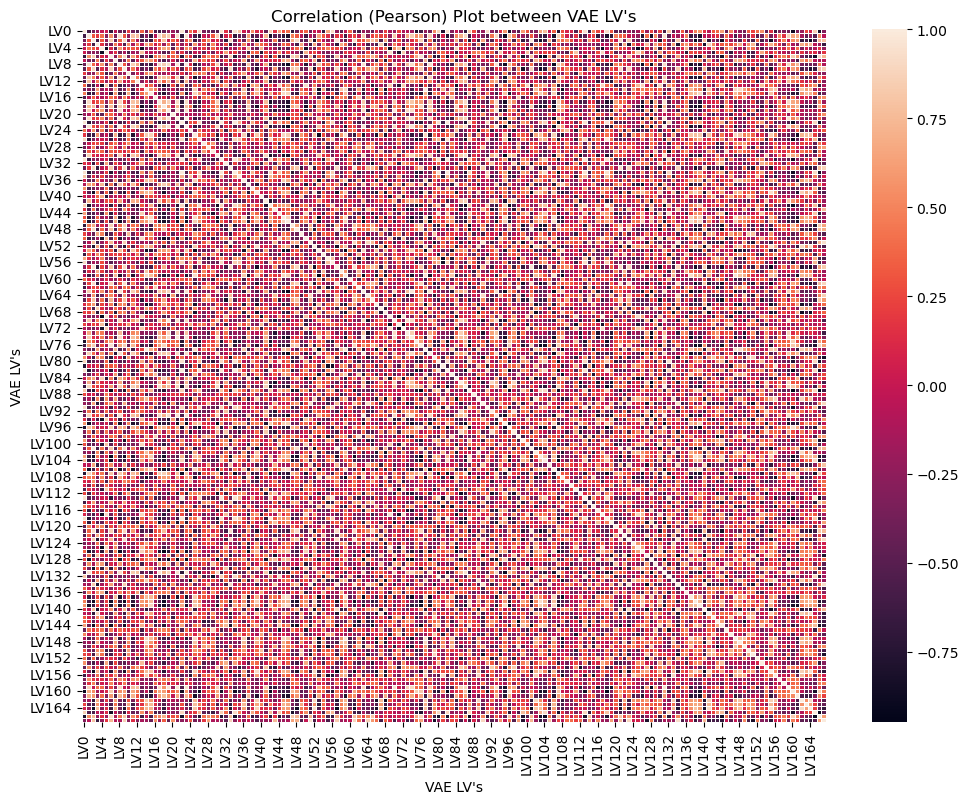

In [123]:
plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_pearson_vae_df, cmap="rocket", linewidths=.5)

plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("VAE LV's") # Customize the Y-axis label

plt.title("Correlation (Pearson) Plot between VAE LV's") # Customize the title
plt.show()

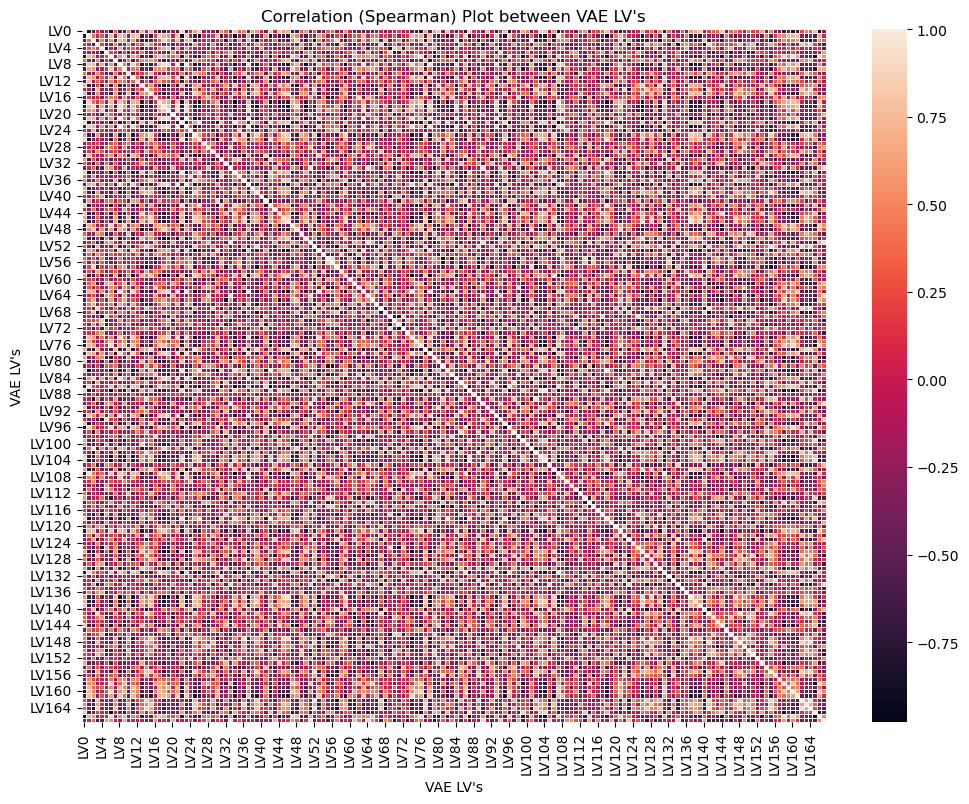

In [124]:
plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_spearman_vae_df, cmap="rocket",linewidths=.5)

plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("VAE LV's") # Customize the Y-axis label

plt.title("Correlation (Spearman) Plot between VAE LV's") # Customize the title
plt.show()

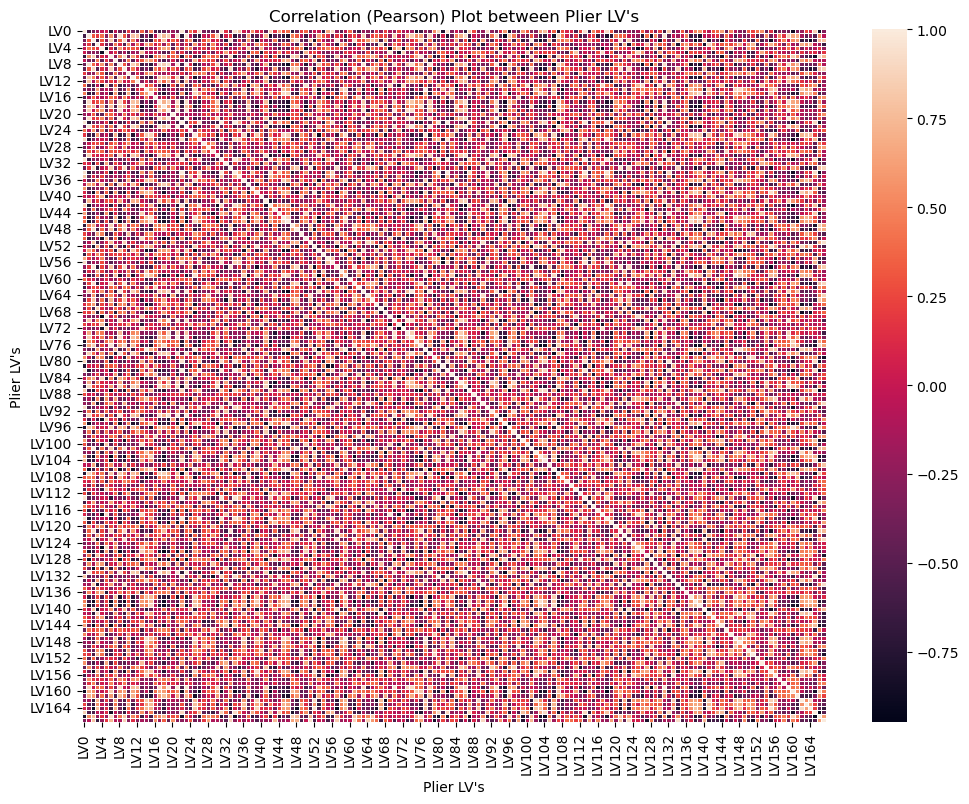

In [125]:
plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_pearson_plier_df, cmap="rocket",linewidths=.5)

plt.xlabel("Plier LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Correlation (Pearson) Plot between Plier LV's") # Customize the title
plt.show()

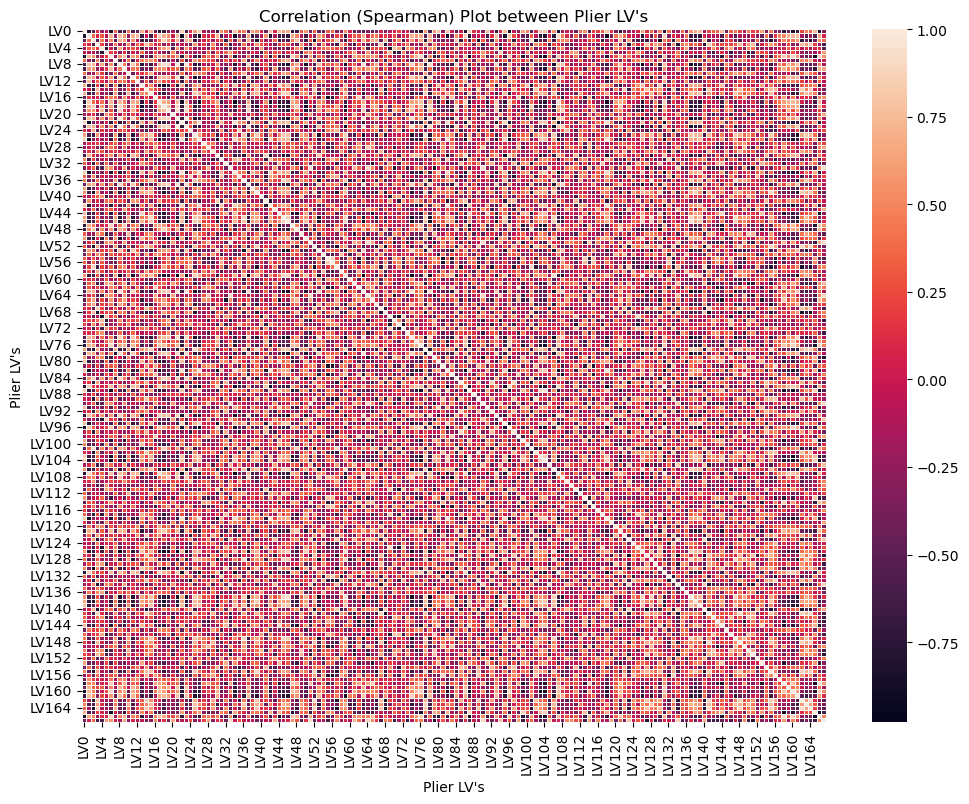

In [126]:
plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_spearman_plier_df, cmap="rocket",linewidths=.5)

plt.xlabel("Plier LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Correlation (Spearman) Plot between Plier LV's") # Customize the title
plt.show()

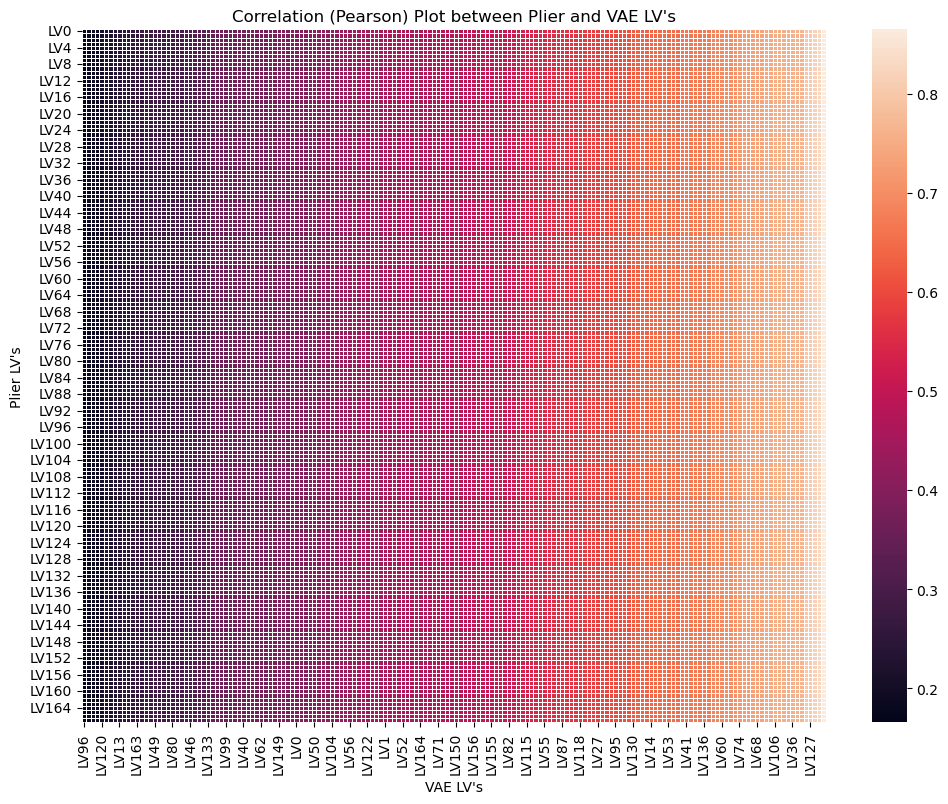

In [127]:
correlation_matrix_pearson_plier_vae_max = correlation_matrix_pearson_plier_vae_df.max(axis=0).sort_values()
key_list_sorted = correlation_matrix_pearson_plier_vae_max.index.tolist()
correlation_matrix_pearson_plier_vae_sort_df = correlation_matrix_pearson_plier_vae_df.reindex(columns=key_list_sorted)
for col in correlation_matrix_pearson_plier_vae_sort_df:
    correlation_matrix_pearson_plier_vae_sort_df[col] = [correlation_matrix_pearson_plier_vae_max[col]]*correlation_matrix_pearson_plier_vae_sort_df.shape[1] 


plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_pearson_plier_vae_sort_df, cmap="rocket",linewidths=0.5)
plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Correlation (Pearson) Plot between Plier and VAE LV's") # Customize the title
plt.show()

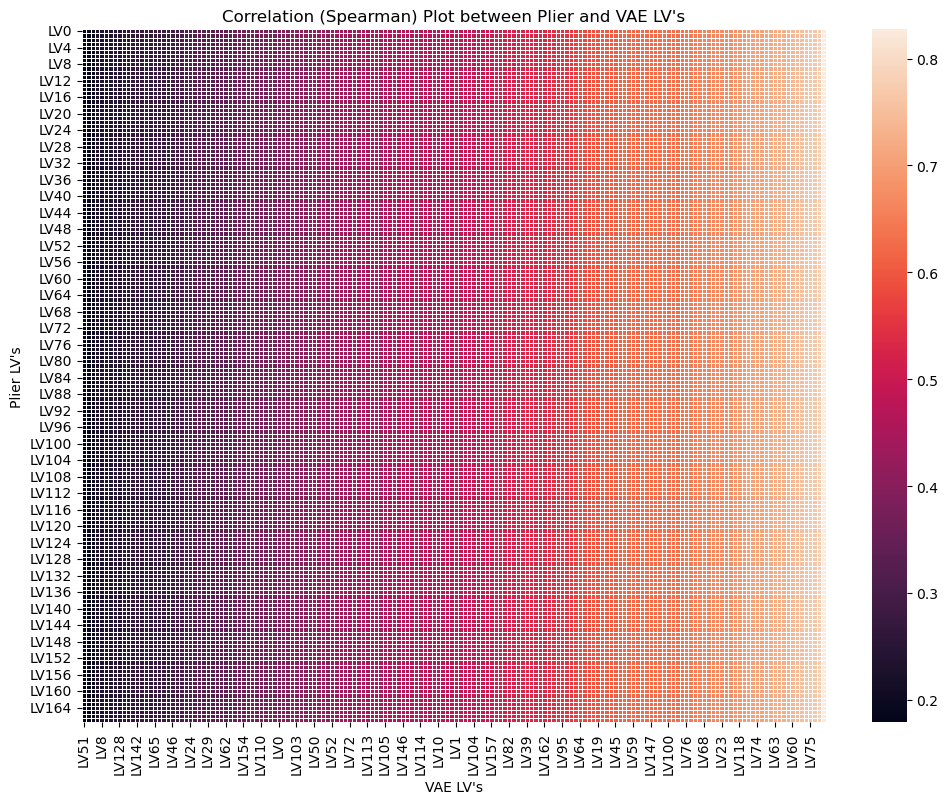

In [128]:
correlation_matrix_spearman_plier_vae_max = correlation_matrix_spearman_plier_vae_df.max(axis=0).sort_values()
key_list_sorted = correlation_matrix_spearman_plier_vae_max.index.tolist()
correlation_matrix_spearman_plier_vae_sort_df = correlation_matrix_spearman_plier_vae_df.reindex(columns=key_list_sorted)
for col in correlation_matrix_spearman_plier_vae_sort_df:
    correlation_matrix_spearman_plier_vae_sort_df[col] = [correlation_matrix_spearman_plier_vae_max[col]]*correlation_matrix_spearman_plier_vae_sort_df.shape[1] 


plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_spearman_plier_vae_sort_df, cmap="rocket",linewidths=0.5)
plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Correlation (Spearman) Plot between Plier and VAE LV's") # Customize the title
plt.show()

# Two Group Permutation Test

In [129]:
def plot_null_distribution(null_dist, observed, p_value, model_type = "VAE"):
    plt.figure(figsize=(7, 4))
    sns.histplot(null_dist, bins=100, kde=False, color='green')
    plt.axvline(observed, color='red', linestyle='--', label='Observed')
    plt.title(f'Null distribution for significant lv count ({model_type})')
    plt.xlabel('null dist of significant lvs count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.text(90, 80, f'p-value :{p_value}', fontsize=9)
    plt.show()
    
def plot_null_distribution_per_lv(null_dist, observed, lv_list, lv_idx, model_type = "VAE"):
    plt.figure(figsize=(7, 4))
    sns.histplot(null_dist[:, lv_idx], bins=30, kde=True, color='lightblue')
    plt.axvline(observed[lv_idx], color='red', linestyle='--', label='Observed')
    plt.title(f'Null distribution for  {lv_list[lv_idx]} ({model_type})')
    plt.xlabel('Mean difference (perm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
def incremental_shuffles_samples(label_sample_dict):
    label_sample_dict_temp = {} 
    sample_list = [] 
    for label, samples in label_sample_dict.items():
        sample_list.extend(samples)

    for label, samples in label_sample_dict.items():
        temp = random.sample(sample_list, len(samples))
        label_sample_dict_temp[label] = temp
        for sample in temp:
            sample_list.remove(sample)

    return label_sample_dict_temp

def single_group_test(B_df, group, label_sample_dict, seed=42):
    """
    Parameters:
        B_df: (n_samples, n_lvs) lv's expression matrix
        label_sample_dict,: (n_samples,) array of group labels
        seed: random seed
        
    Returns:
        DataFrame with gene index, observed F, p-value, adjusted p-value
    """
    np.random.seed(seed)
    n_samples, n_lvs = B_df.shape
    lv_list = B_df.columns.tolist()
    
    # Compute observed F-statistics
    group_0 = B_df.loc[label_sample_dict[group]]
    # observed_mean = (group_0.mean(axis=0)).to_numpy()
    group_rest = B_df.loc[~B_df.index.isin(label_sample_dict[group])]
    p_vals = np.zeros(n_lvs)
    for idx, lv in enumerate(lv_list):
        _, p_vals[idx] = ranksums(group_0[lv], group_rest[lv])
    
    # FDR correction (Benjamini-Hochberg)
    _, p_adj, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    return pd.DataFrame({
        'lv': lv_list,
        'p_value': p_vals,
        'p_adj': p_adj,
    }).sort_values('p_adj')

def permutation_test_multigroup_lv_count(B_df, label_sample_dict, n_permutations=1000, seed=42):
    np.random.seed(seed)
    sign_lv_set = set()
    for group in label_sample_dict:
        test = single_group_test(B_df, group, label_sample_dict, seed=42)
        sign_lv_set = sign_lv_set.union(test[test['p_adj'] < 0.05]['lv'].tolist())
    
    observed_sign_lvs_count = len(sign_lv_set)

    null_lvs_count_distribution = np.zeros((n_permutations,))
    for p in range(n_permutations):
        label_sample_dict_perm = incremental_shuffles_samples(label_sample_dict)
        sign_lv_set_perm = set()
        for group in label_sample_dict_perm:
            test_perm = single_group_test(B_df, group, label_sample_dict_perm, seed=42)
            sign_lv_set_perm = sign_lv_set_perm.union(test_perm[test_perm['p_adj'] < 0.05]['lv'].tolist())

        null_lvs_count_distribution[p] = len(sign_lv_set_perm)
        
    p_vals = np.mean(null_lvs_count_distribution >=  observed_sign_lvs_count, axis=0)
    
    # FDR correction (Benjamini-Hochberg)
    _, p_adj, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    return pd.DataFrame({
        'lvs_count': observed_sign_lvs_count,
        'p_value': p_vals,
        'p_adj': p_adj,
    }).sort_values('p_adj'), null_lvs_count_distribution, sign_lv_set 

    
        
def permutation_test_twogroup(B_df, two_groups, label_sample_dict, n_permutations=1000, seed=42):

    """
    Permutation-based one-way ANOVA for multiple groups (one test per gene).
    
    Parameters:
        B_df: (n_samples, n_lvs) lv's expression matrix
        label_sample_dict,: (n_samples,) array of group labels
        n_permutations: number of permutations
        seed: random seed
        
    Returns:
        DataFrame with gene index, observed F, p-value, adjusted p-value
    """
    np.random.seed(seed)
    n_samples, n_lvs = B_df.shape
    lv_list = B_df.columns.tolist()
    
    # Compute observed F-statistics
    group_0 = B_df.loc[label_sample_dict[two_groups[0]]]
    group_1 = B_df.loc[label_sample_dict[two_groups[1]]]
    observed_mean_diff = (group_0.mean(axis=0) - group_1.mean(axis=0)).to_numpy()
    

    # Permute group labels and compute mean diff 
    null_mean_diff_distribution = np.zeros((n_permutations, n_lvs))
    for p in range(n_permutations):
        label_sample_dict_perm = incremental_shuffles_samples(label_sample_dict)
        group_0 = B_df.loc[label_sample_dict_perm[two_groups[0]]]
        group_1 = B_df.loc[label_sample_dict_perm[two_groups[1]]]
        null_mean_diff_distribution[p, :] = (group_0.mean(axis=0) - group_1.mean(axis=0)).to_numpy()
        
    # Compute Two-sided p-values
    p_vals = np.mean(np.abs(null_mean_diff_distribution) >= np.abs(observed_mean_diff), axis=0)
    
    # FDR correction (Benjamini-Hochberg)
    _, p_adj, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    return pd.DataFrame({
        'lv': lv_list,
        'mean_diff': observed_mean_diff,
        'p_value': p_vals,
        'p_adj': p_adj,
    }).sort_values('p_adj'), null_mean_diff_distribution
    
    
    
def permutation_test_multigroup(B_df, label_sample_dict, n_permutations=1000, seed=42):
    """
    Permutation-based one-way ANOVA for multiple groups (one test per gene).
    
    Parameters:
        B_df: (n_samples, n_lvs) lv's expression matrix
        label_sample_dict,: (n_samples,) array of group labels
        n_permutations: number of permutations
        seed: random seed
        
    Returns:
        DataFrame with gene index, observed F, p-value, adjusted p-value
    """
    np.random.seed(seed)
    n_samples, n_lvs = B_df.shape
    groups = list(label_sample_dict.keys())
    lv_list = B_df.columns.tolist()
    
    # Compute observed F-statistics
    observed_f = np.zeros(n_lvs)
    for idx, lv in enumerate(lv_list):
        data_by_group = [B_df.loc[label_sample_dict[g]][lv].to_numpy() for g in groups]
        observed_f[idx], _ = f_oneway(*data_by_group)
    
    # Permute group labels and compute F-statistics
    perm_f = np.zeros((n_permutations, n_lvs))
    for p in range(n_permutations):
        # y_perm = np.random.permutation(y)
        label_sample_dict_perm = incremental_shuffles_samples(label_sample_dict)
        for idx, lv in enumerate(lv_list):
            data_by_group = [B_df.loc[label_sample_dict_perm[g]][lv].to_numpy() for g in groups]
            f_stat, _ = f_oneway(*data_by_group)
            perm_f[p, idx] = f_stat
    
    # Compute empirical p-values
    print(perm_f.shape, observed_f.shape)
    p_vals = np.mean(perm_f >= observed_f, axis=0)
    
    # FDR correction (Benjamini-Hochberg)
    _, p_adj, _, _ = multipletests(p_vals, method='fdr_bh')
    
    return pd.DataFrame({
        'lv_index': lv_list,
        'F_stat': observed_f,
        'p_value': p_vals,
        'p_adj': p_adj
    }).sort_values('p_adj')

In [130]:
test_vae, null_mean_diff_distribution_vae = permutation_test_twogroup(B_vae, ["heart", "brain"], new_dataset_label_sample_dict, n_permutations=100, seed=42)

In [131]:
print(test_vae[test_vae['p_adj'] < 0.05])

        lv  mean_diff  p_value     p_adj
3      LV3  -0.471908     0.00  0.000000
7      LV7   0.497423     0.00  0.000000
6      LV6   0.332367     0.00  0.000000
12    LV12   0.206349     0.00  0.000000
25    LV25  -0.331866     0.00  0.000000
..     ...        ...      ...       ...
161  LV161  -0.192249     0.01  0.021000
157  LV157  -0.273681     0.01  0.021000
38    LV38  -0.198623     0.02  0.040482
159  LV159  -0.178188     0.02  0.040482
73    LV73  -0.196844     0.02  0.040482

[83 rows x 4 columns]


In [132]:
test_plier, null_mean_diff_distribution_plier = permutation_test_twogroup(B_plier, ["heart", "brain"], new_dataset_label_sample_dict, n_permutations=100, seed=42)

In [133]:
print(test_plier[test_plier['p_adj'] < 0.05])

        lv  mean_diff  p_value     p_adj
0      LV0  -0.110072     0.00  0.000000
3      LV3   0.009945     0.00  0.000000
7      LV7   0.022510     0.00  0.000000
14    LV14   0.177981     0.00  0.000000
28    LV28   0.013679     0.00  0.000000
..     ...        ...      ...       ...
111  LV111   0.025064     0.01  0.019535
86    LV86   0.008108     0.02  0.037333
74    LV74  -0.014210     0.02  0.037333
65    LV65   0.011882     0.02  0.037333
129  LV129   0.004883     0.02  0.037333

[90 rows x 4 columns]


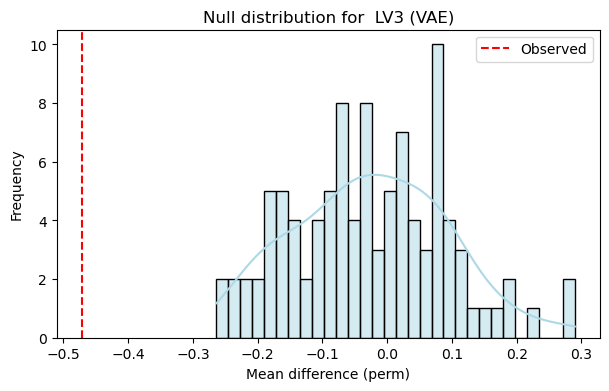

In [134]:
plot_null_distribution_per_lv(null_mean_diff_distribution_vae, test_vae["mean_diff"], test_vae["lv"], 3, model_type="VAE")

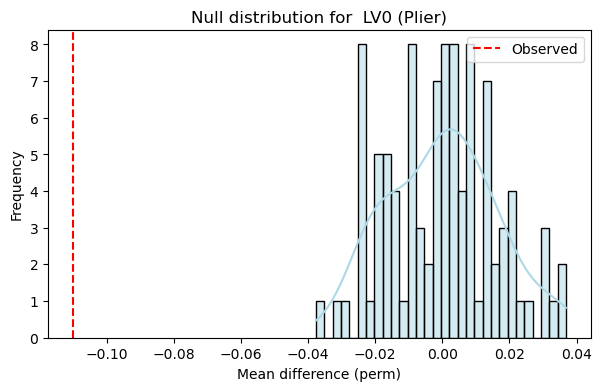

In [135]:
plot_null_distribution_per_lv(null_mean_diff_distribution_plier, test_plier["mean_diff"], test_plier["lv"], 0, model_type="Plier")

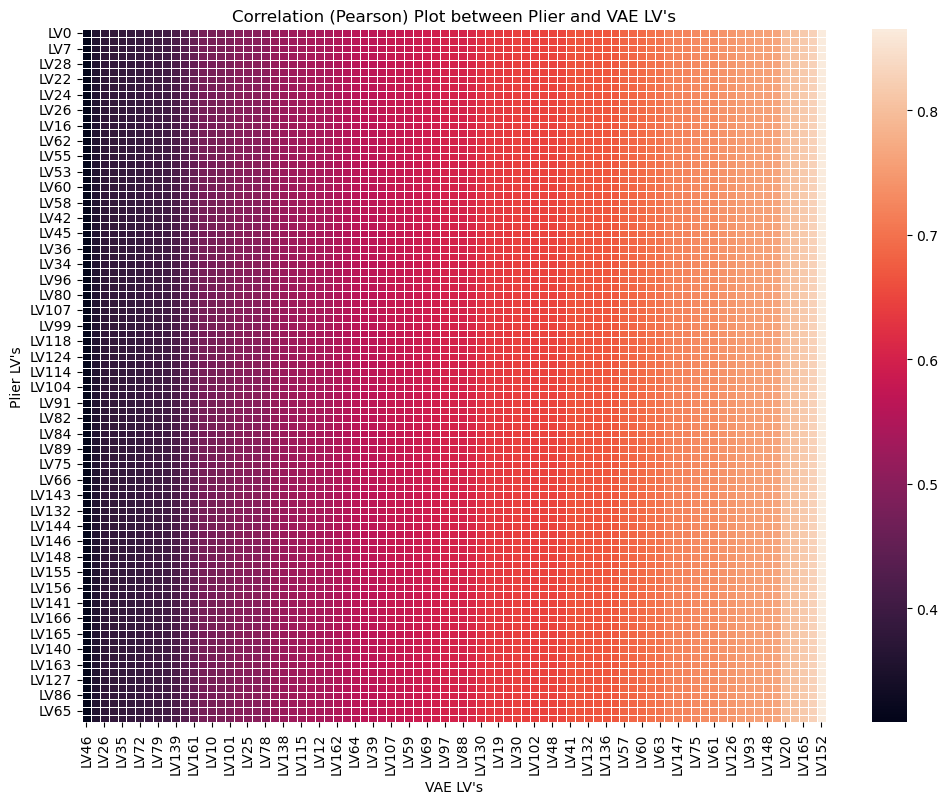

In [136]:
correlation_matrix_pearson_plier_vae_subset_df = correlation_matrix_pearson_plier_vae_df[test_vae[test_vae['p_adj'] < 0.05]["lv"].tolist()]
correlation_matrix_pearson_plier_vae_subset_df = correlation_matrix_pearson_plier_vae_subset_df.loc[test_plier[test_plier['p_adj'] < 0.05]["lv"].tolist()]
correlation_matrix_pearson_plier_vae_max = correlation_matrix_pearson_plier_vae_subset_df.max(axis=0).sort_values()
key_list_sorted = correlation_matrix_pearson_plier_vae_max.index.tolist()
correlation_matrix_pearson_plier_vae_sort_df = correlation_matrix_pearson_plier_vae_subset_df.reindex(columns=key_list_sorted)
# print(correlation_matrix_pearson_plier_vae_sort_df.columns)

for col in correlation_matrix_pearson_plier_vae_sort_df:
    correlation_matrix_pearson_plier_vae_sort_df[col] = [correlation_matrix_pearson_plier_vae_max[col]]*correlation_matrix_pearson_plier_vae_sort_df.shape[0] 


plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_pearson_plier_vae_sort_df, cmap="rocket",linewidths=0.5)
plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Correlation (Pearson) Plot between Plier and VAE LV's") # Customize the title
plt.show()

In [137]:
test_vae_ranksum = single_group_test(B_vae, "brain", new_dataset_label_sample_dict)

In [138]:
test_vae_ranksum[test_vae_ranksum['p_adj'] < 0.5]

,lv,p_value,p_adj
132,LV132,4.971629e-08,0.000008
118,LV118,1.412675e-06,0.000119
48,LV48,2.285113e-06,0.000128
31,LV31,3.133084e-06,0.000132
27,LV27,1.429541e-05,0.000480
...,...,...,...
157,LV157,3.172476e-01,0.471660
75,LV75,3.172476e-01,0.471660
8,LV8,3.331104e-01,0.482436
24,LV24,3.331104e-01,0.482436


In [139]:
test_plier_ranksum = single_group_test(B_plier, "heart", new_dataset_label_sample_dict)

In [140]:
test_plier_ranksum[test_plier_ranksum['p_adj'] < 0.5]

,lv,p_value,p_adj
14,LV14,4.001604e-09,3.734831e-08
25,LV25,4.001604e-09,3.734831e-08
59,LV59,4.001604e-09,3.734831e-08
56,LV56,4.001604e-09,3.734831e-08
53,LV53,4.001604e-09,3.734831e-08
...,...,...,...
80,LV80,3.492160e-01,4.313844e-01
0,LV0,3.578891e-01,4.388713e-01
34,LV34,3.666965e-01,4.464131e-01
153,LV153,3.847126e-01,4.649763e-01


In [141]:
test_vae, null_lvs_count_distribution_vae, sign_lv_set_vae = permutation_test_multigroup_lv_count(B_vae, new_dataset_label_sample_dict, n_permutations=100, seed=42)

In [142]:
test_vae[test_vae['p_adj'] < 0.05]

,lvs_count,p_value,p_adj
0,117,0.0,0.0


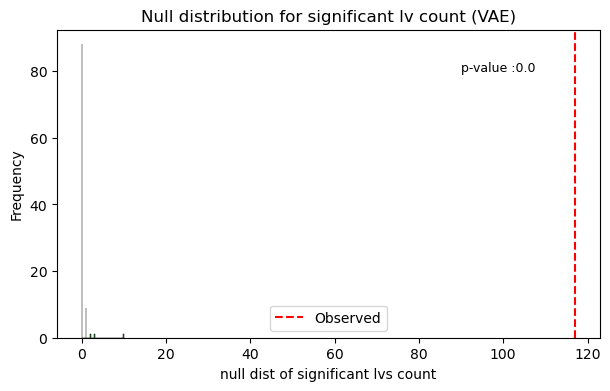

In [168]:
plot_null_distribution(null_lvs_count_distribution_vae, test_vae["lvs_count"].tolist()[0], test_vae['p_value'][0], model_type="VAE")

In [144]:
test_plier, null_lvs_count_distribution_plier, sign_lv_set_plier = permutation_test_multigroup_lv_count(B_plier, new_dataset_label_sample_dict, n_permutations=100, seed=42)

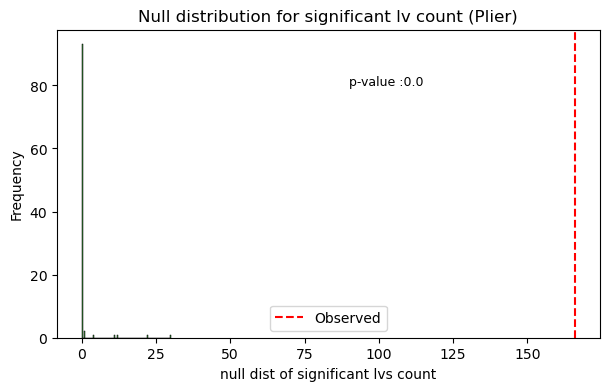

In [169]:
plot_null_distribution(null_lvs_count_distribution_plier, test_plier["lvs_count"].tolist()[0], test_plier['p_value'][0], model_type="Plier")

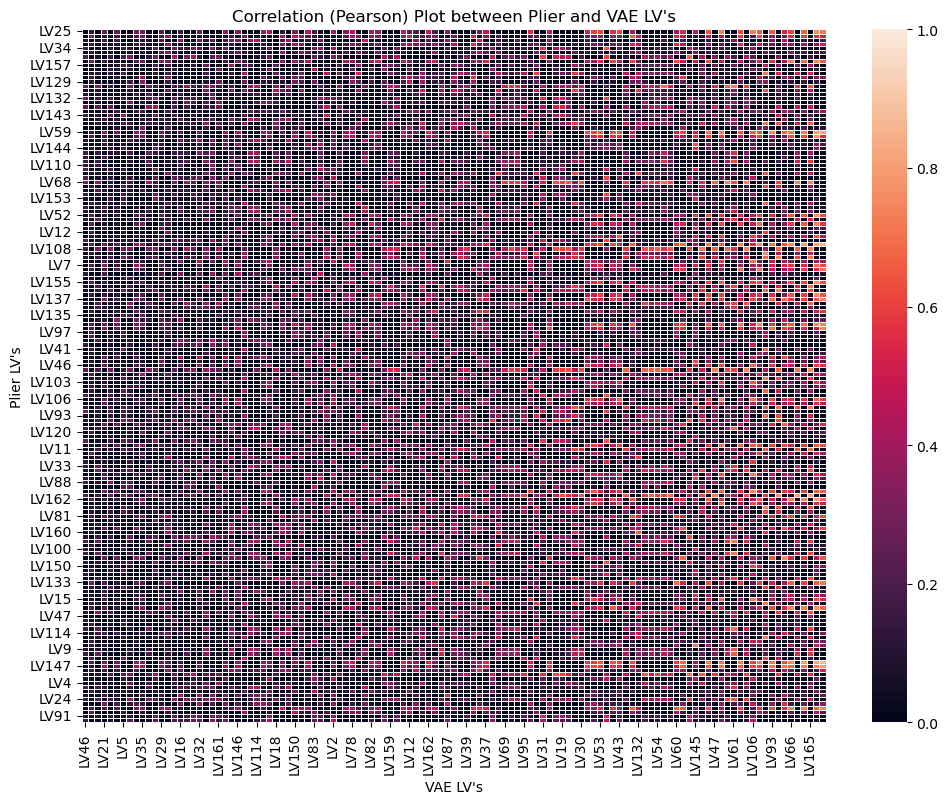

In [170]:
correlation_matrix_pearson_plier_vae_subset_df = correlation_matrix_pearson_plier_vae_df[list(sign_lv_set_vae)]
correlation_matrix_pearson_plier_vae_subset_df = correlation_matrix_pearson_plier_vae_subset_df.loc[list(sign_lv_set_plier)]
correlation_matrix_pearson_plier_vae_max = correlation_matrix_pearson_plier_vae_subset_df.max(axis=0).sort_values()
key_list_sorted = correlation_matrix_pearson_plier_vae_max.index.tolist()
correlation_matrix_pearson_plier_vae_sort_df = correlation_matrix_pearson_plier_vae_subset_df.reindex(columns=key_list_sorted)
# for col in correlation_matrix_pearson_plier_vae_sort_df:
#     correlation_matrix_pearson_plier_vae_sort_df[col] = [correlation_matrix_pearson_plier_vae_max[col]]*correlation_matrix_pearson_plier_vae_sort_df.shape[0] 


plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_pearson_plier_vae_sort_df, vmin=0, vmax=1, cmap="rocket",linewidths=0.5)
plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Correlation (Pearson) Plot between Plier and VAE LV's") # Customize the title
plt.show()

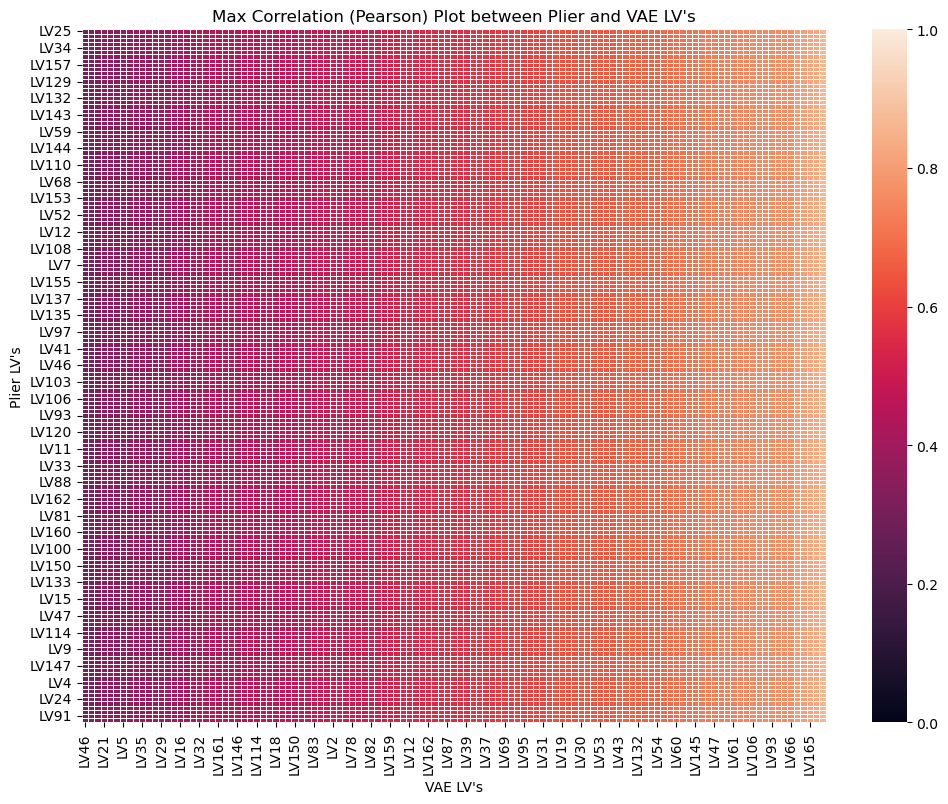

In [171]:
correlation_matrix_pearson_plier_vae_subset_df = correlation_matrix_pearson_plier_vae_df[list(sign_lv_set_vae)]
correlation_matrix_pearson_plier_vae_subset_df = correlation_matrix_pearson_plier_vae_subset_df.loc[list(sign_lv_set_plier)]
correlation_matrix_pearson_plier_vae_max = correlation_matrix_pearson_plier_vae_subset_df.max(axis=0).sort_values()
key_list_sorted = correlation_matrix_pearson_plier_vae_max.index.tolist()
correlation_matrix_pearson_plier_vae_sort_df = correlation_matrix_pearson_plier_vae_subset_df.reindex(columns=key_list_sorted)
correlation_matrix_pearson_plier_vae_max_sort_df = correlation_matrix_pearson_plier_vae_sort_df.copy()
for col in correlation_matrix_pearson_plier_vae_sort_df:
    correlation_matrix_pearson_plier_vae_max_sort_df[col] = [correlation_matrix_pearson_plier_vae_max[col]]*correlation_matrix_pearson_plier_vae_max_sort_df.shape[0] 


plt.figure(figsize=(12, 9))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_pearson_plier_vae_max_sort_df, vmin=0, vmax=1, cmap="rocket",linewidths=0.5)
plt.xlabel("VAE LV's") # Customize the X-axis label
plt.ylabel("Plier LV's") # Customize the Y-axis label

plt.title("Max Correlation (Pearson) Plot between Plier and VAE LV's") # Customize the title
plt.show()

/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


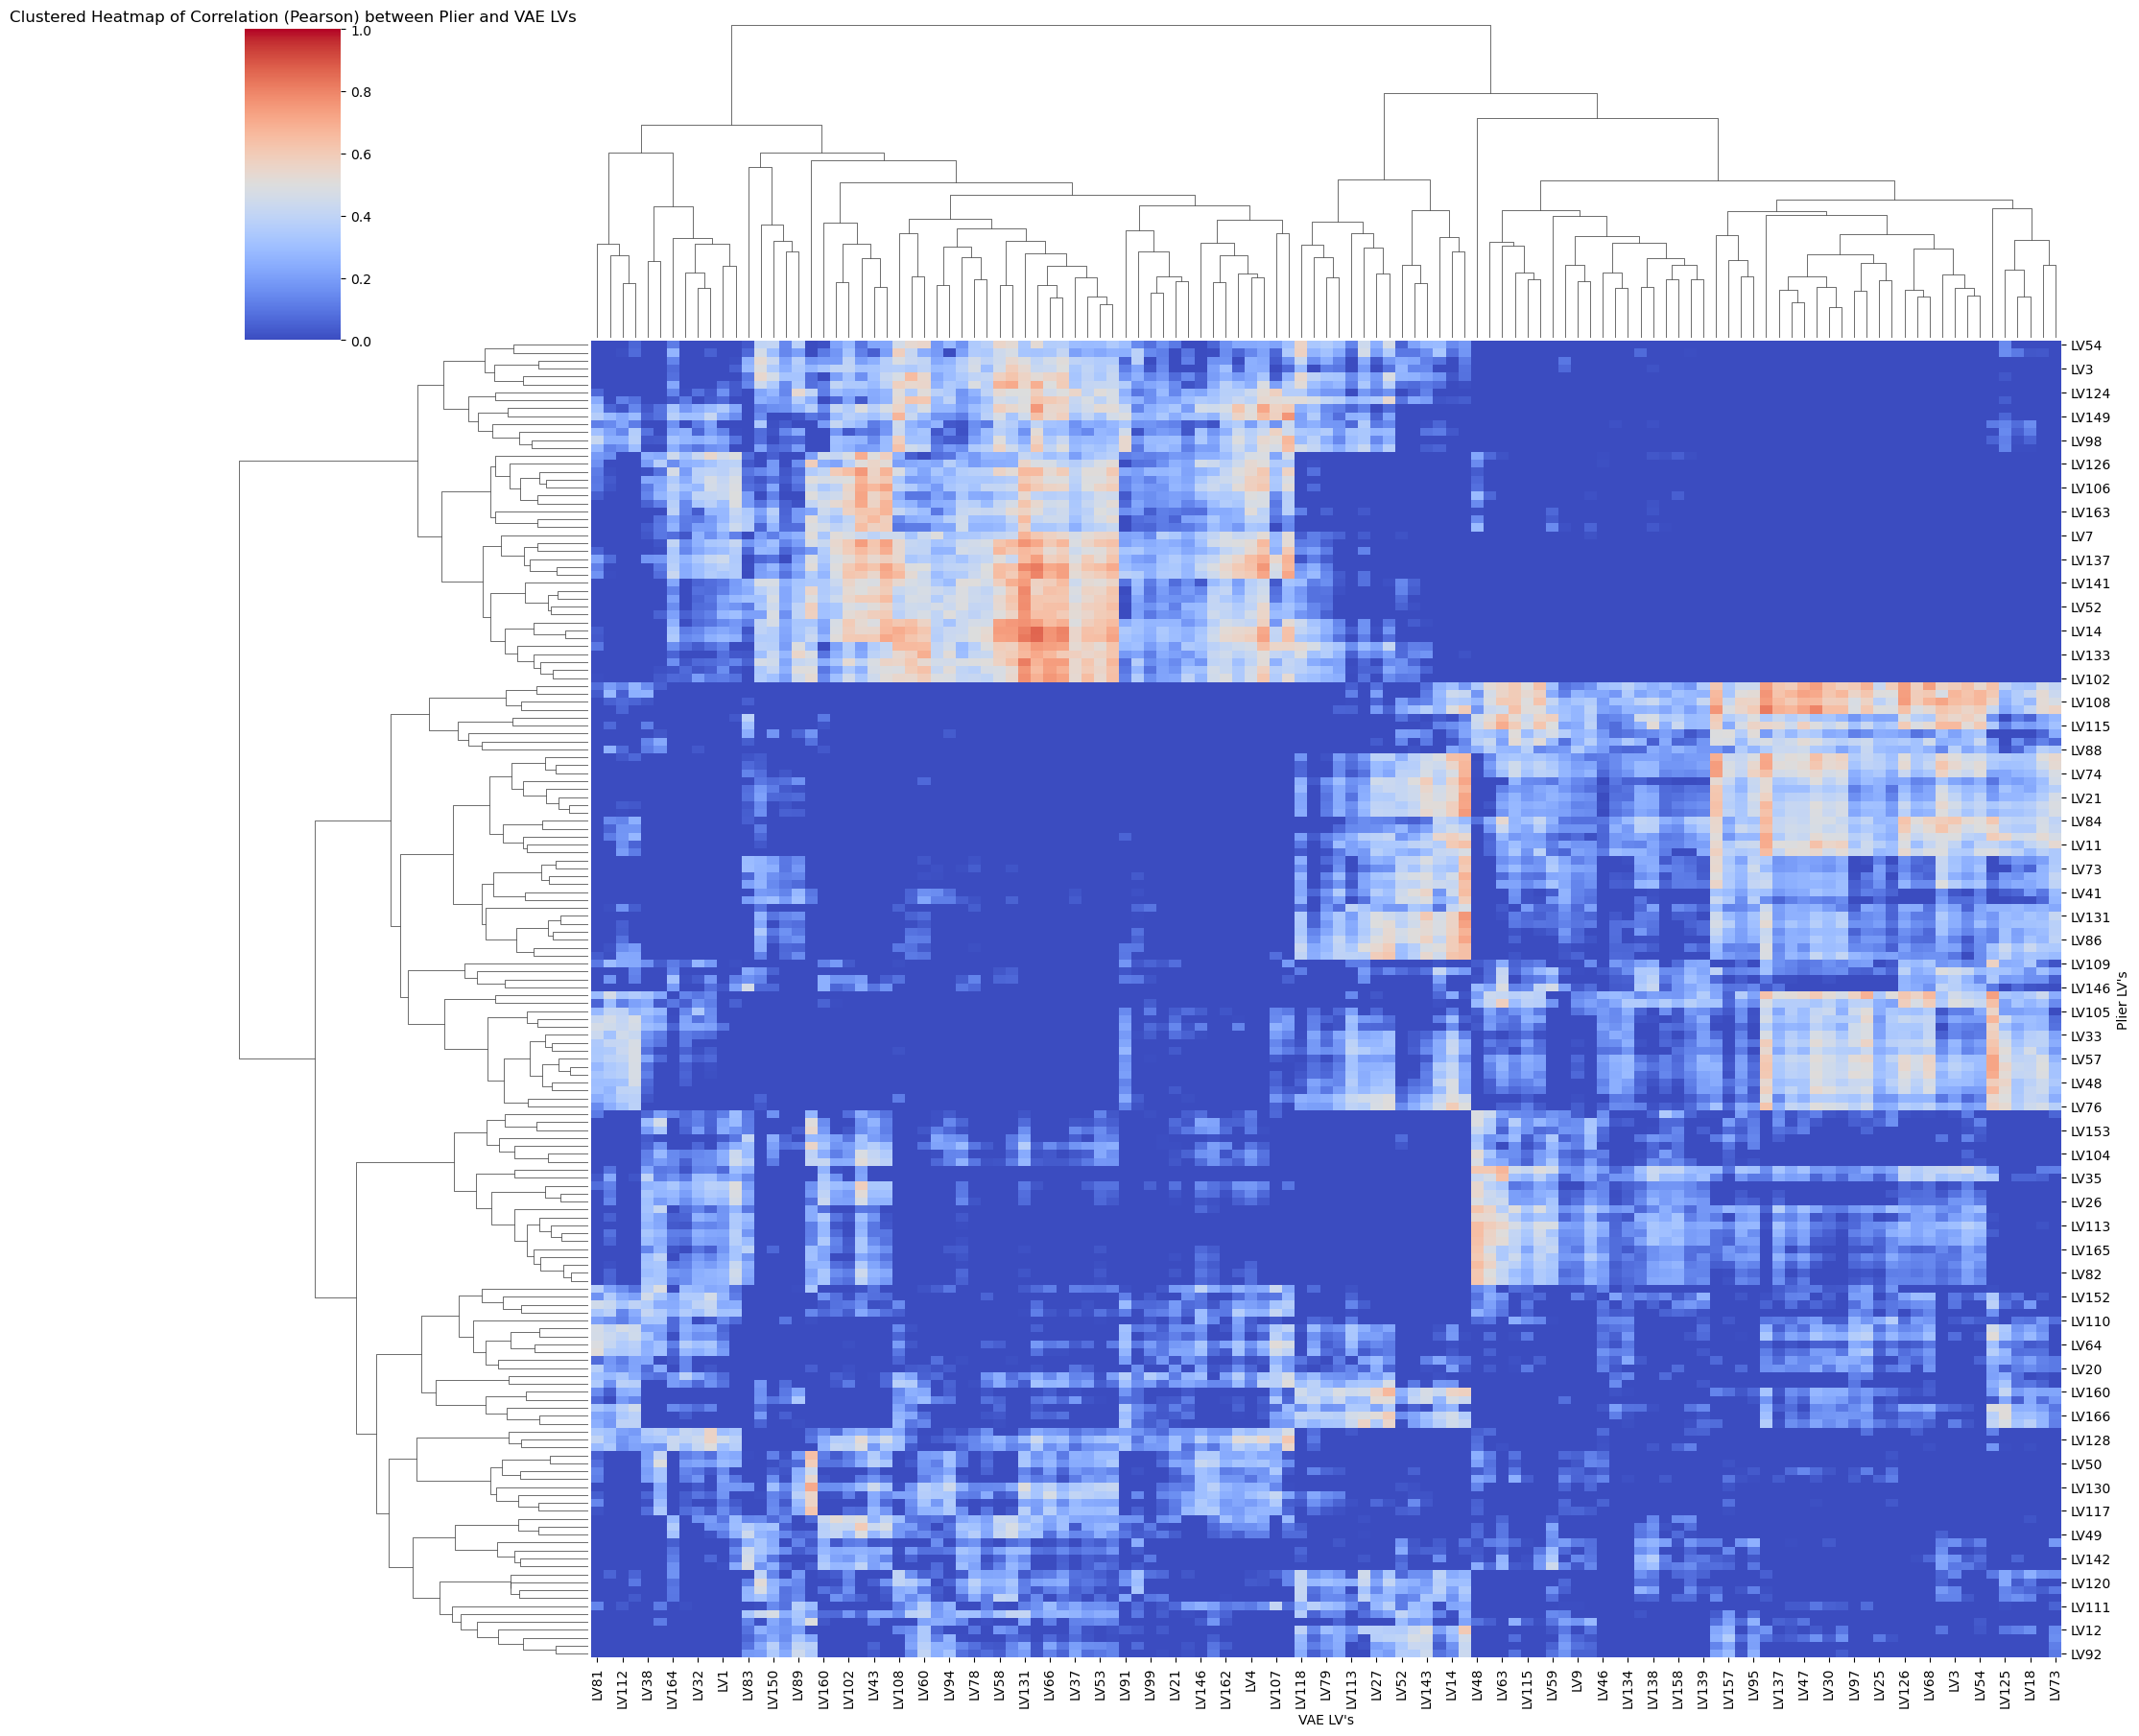

In [172]:
g = sns.clustermap(correlation_matrix_pearson_plier_vae_sort_df, vmin=0, vmax=1, cmap='coolwarm', figsize=(20, 18))
plt.title('Clustered Heatmap of Correlation (Pearson) between Plier and VAE LVs')
g.ax_heatmap.set_xlabel("VAE LV's")
g.ax_heatmap.set_ylabel("Plier LV's")
plt.show()